<a href="https://colab.research.google.com/github/Kalazclint/River_gage_height_forecasting/blob/main/LSTM_GRU_CONVLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path = '/content/drive/My Drive/dataset_2015_2020.xlsx'
data = pd.read_excel(path)
data.head()

,Date/Time,gage_height_ft_sensor_07377600,gage_height_ft_sensor_07377760,gage_height_ft_sensor_07378050,gage_height_ft_sensor_07380120
0,2015-01-01 00:00:00-06:00,13.79,1.91,17.87,1.70
1,2015-01-01 00:15:00-06:00,13.79,1.91,17.85,1.71
2,2015-01-01 00:30:00-06:00,13.79,1.90,17.86,1.72
3,2015-01-01 00:45:00-06:00,13.79,1.90,17.85,1.72
4,2015-01-01 01:00:00-06:00,13.79,1.90,17.85,1.72


In [ ]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

In [ ]:
#Resetting Index to Date data
data.set_index('Date/Time', inplace=True)

In [ ]:
# Separate features and target
features = data.drop('gage_height_ft_sensor_07380120', axis=1)
target = data['gage_height_ft_sensor_07380120']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
split_point = int(len(features) * 0.8)
# Split the features
features_train = features[:split_point]
features_test = features[split_point:]

# Split the target
target_train = target[:split_point]
target_test = target[split_point:]

In [ ]:
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
target_train = scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test = scaler.transform(target_test.values.reshape(-1, 1))

In [ ]:
# Define root mean squared error function
def root_mean_squared_error(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))


In [ ]:
# Define Transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Define the parameters
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


In [ ]:
# Build the model
inputs = layers.Input(shape=(features_train.shape[1], 1))
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="linear")(x)


In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=root_mean_squared_error,
              optimizer=keras.optimizers.Adam(learning_rate=0.0065))


In [ ]:
# Train the model
history = model.fit(
    np.expand_dims(features_train, -1), target_train,
    batch_size=32,
    epochs=50,
    validation_data=(np.expand_dims(features_test, -1), target_test),
)

Epoch 1/50
5261/5261 [==============================] - 33s 6ms/step - loss: 0.9099 - val_loss: 0.4620
Epoch 2/50
5261/5261 [==============================] - 30s 6ms/step - loss: 0.9091 - val_loss: 0.4620
Epoch 3/50
5261/5261 [==============================] - 30s 6ms/step - loss: 0.9081 - val_loss: 0.4634
Epoch 4/50
5261/5261 [==============================] - 31s 6ms/step - loss: 0.9078 - val_loss: 0.4623
Epoch 5/50
5261/5261 [==============================] - 31s 6ms/step - loss: 0.9092 - val_loss: 0.4622
Epoch 6/50
5261/5261 [==============================] - 30s 6ms/step - loss: 0.9083 - val_loss: 0.4635
Epoch 7/50
5261/5261 [==============================] - 31s 6ms/step - loss: 0.9089 - val_loss: 0.4619
Epoch 8/50
5261/5261 [==============================] - 31s 6ms/step - loss: 0.9077 - val_loss: 0.4625
Epoch 9/50
5261/5261 [==============================] - 33s 6ms/step - loss: 0.9076 - val_loss: 0.4621
Epoch 10/50
5261/5261 [==============================] - 31s 6ms/step - l

In [ ]:
train_predict_trans = model.predict(features_train)
test_predict_trans = model.predict(features_test)

1316/1316 [==============================] - 5s 4ms/step


In [ ]:
train_predict_trans = scaler.inverse_transform(train_predict_trans)
target_train_trans = scaler.inverse_transform(target_train)
test_predict_trans = scaler.inverse_transform(test_predict_trans)
target_test_trans = scaler.inverse_transform(target_test)

In [ ]:
target_test_trans

array([[3.44],
       [3.43],
       [3.45],
       ...,
       [2.35],
       [2.35],
       [2.33]])

In [ ]:
test_predict_trans

array([[2.3687088],
       [2.3687088],
       [2.3687088],
       ...,
       [2.3687088],
       [2.3687088],
       [2.3687088]], dtype=float32)

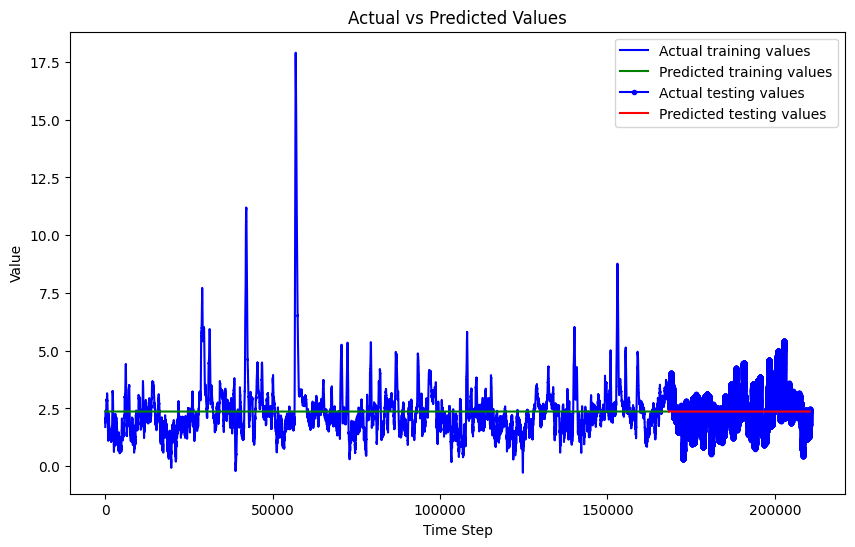

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(target_train_trans, 'blue', label='Actual training values')
plt.plot(train_predict_trans, 'green', label='Predicted training values')

plt.plot(range(len(target_train_trans), len(target_train_trans) + len(target_test_trans)), target_test_trans, 'blue', marker='.', label='Actual testing values')
plt.plot(range(len(target_train_trans), len(target_train_trans) + len(target_test_trans)), test_predict_trans, 'red', label='Predicted testing values')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Compute the RMSE for train data
train_rmse_trans = math.sqrt(mean_squared_error(target_train_trans, train_predict_trans))

# Compute the RMSE for test data
test_rmse_trans = math.sqrt(mean_squared_error(target_test_trans, test_predict_trans))

print(f'Train RMSE: {train_rmse_trans}')
print(f'Test RMSE: {test_rmse_trans}')

Train RMSE: 1.2753366325269293
Test RMSE: 0.771607496472591


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5

# Reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(features_train, target_train, time_steps)
X_test, y_test = create_dataset(features_test, target_test, time_steps)


Epoch 1/5
5261/5261 [==============================] - 16s 3ms/step - loss: 1.7752
Epoch 2/5
5261/5261 [==============================] - 14s 3ms/step - loss: 0.7351
Epoch 3/5
5261/5261 [==============================] - 14s 3ms/step - loss: 0.5653
Epoch 4/5
5261/5261 [==============================] - 15s 3ms/step - loss: 0.6345
Epoch 5/5
5261/5261 [==============================] - 1s 106us/step - loss: 14.0346


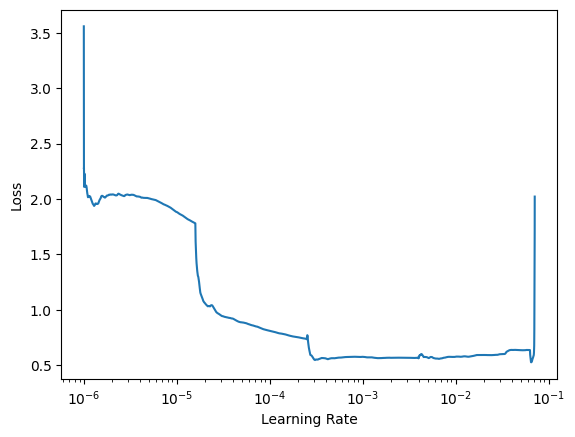

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Find the optimal learning rate
lrf = LearningRateFinder(model)
lrf.find(X_train, y_train, start_lr=1e-6, end_lr=1, batch_size=32, epochs=5)

# Plot the loss
lrf.plot_loss()


In [ ]:
import numpy as np

# Convert the learning rates and losses to numpy arrays
lrs = np.array(lrf.lrs)
losses = np.array(lrf.losses)

# Get the index of the minimum loss
min_loss_idx = np.argmin(losses)

# Get the learning rate at the minimum loss
optimal_lr = lrs[min_loss_idx]

print('Optimal learning rate :', optimal_lr)

Optimal learning rate : 0.0652400481330312


ConvLstm

In [ ]:
# Normalize the features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)


In [ ]:
# Reshape the data for ConvLSTM
features_conv = features.reshape((features.shape[0], 1, 1, 1, features.shape[1]))

# Split the data sequentially
train_size = int(len(features_conv) * 0.8)
features_train_conv, features_test_conv = features_conv[:train_size], features_conv[train_size:]
target_train_conv, target_test_conv = target[:train_size], target[train_size:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense


In [ ]:
# Define the ConvLSTM model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(features_train_conv.shape[1], features_train_conv.shape[2], features_train_conv.shape[3], features_train_conv.shape[4])))
model.add(Flatten())
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(features_train_conv, target_train_conv, epochs=50, verbose=0)

In [ ]:
# Use the trained model to make predictions
train_predictions_conv = model.predict(features_train_conv)
test_predictions_conv = model.predict(features_test_conv)

1316/1316 [==============================] - 2s 2ms/step


In [ ]:
train_predictions_conv

array([[1.9411575],
       [1.9361616],
       [1.9411302],
       ...,
       [2.0773792],
       [2.0798724],
       [2.0798724]], dtype=float32)

In [ ]:
target_train_conv

Date/Time
2015-01-01 00:00:00-06:00    1.70
2015-01-01 00:15:00-06:00    1.71
2015-01-01 00:30:00-06:00    1.72
2015-01-01 00:45:00-06:00    1.72
2015-01-01 01:00:00-06:00    1.72
                             ... 
2019-10-20 13:00:00-06:00    3.40
2019-10-20 13:15:00-06:00    3.40
2019-10-20 13:30:00-06:00    3.41
2019-10-20 13:45:00-06:00    3.43
2019-10-20 14:00:00-06:00    3.43
Name: gage_height_ft_sensor_07380120, Length: 168344, dtype: float64

In [ ]:
test_predictions_conv

array([[2.0823655],
       [2.0797253],
       [2.0772347],
       ...,
       [2.4473934],
       [2.466107 ],
       [2.4818592]], dtype=float32)

In [ ]:
target

Date/Time
2015-01-01 00:00:00-06:00    1.70
2015-01-01 00:15:00-06:00    1.71
2015-01-01 00:30:00-06:00    1.72
2015-01-01 00:45:00-06:00    1.72
2015-01-01 01:00:00-06:00    1.72
                             ... 
2020-12-31 22:45:00-06:00    2.38
2020-12-31 23:00:00-06:00    2.37
2020-12-31 23:15:00-06:00    2.35
2020-12-31 23:30:00-06:00    2.35
2020-12-31 23:45:00-06:00    2.33
Name: gage_height_ft_sensor_07380120, Length: 210431, dtype: float64

In [ ]:
target_test_conv

Date/Time
2019-10-20 14:15:00-06:00    3.44
2019-10-20 14:30:00-06:00    3.43
2019-10-20 14:45:00-06:00    3.45
2019-10-20 15:00:00-06:00    3.44
2019-10-20 15:15:00-06:00    3.47
                             ... 
2020-12-31 22:45:00-06:00    2.38
2020-12-31 23:00:00-06:00    2.37
2020-12-31 23:15:00-06:00    2.35
2020-12-31 23:30:00-06:00    2.35
2020-12-31 23:45:00-06:00    2.33
Name: gage_height_ft_sensor_07380120, Length: 42087, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error of the predictions
train_mse_conv = mean_squared_error(target_train_conv, train_predictions_conv)
test_mse_conv = mean_squared_error(target_test_conv, test_predictions_conv)

print("Train MSE:", train_mse_conv)
print("Test MSE:", test_mse_conv)

Train MSE: 0.7031032142847842
Test MSE: 0.6310282828307475


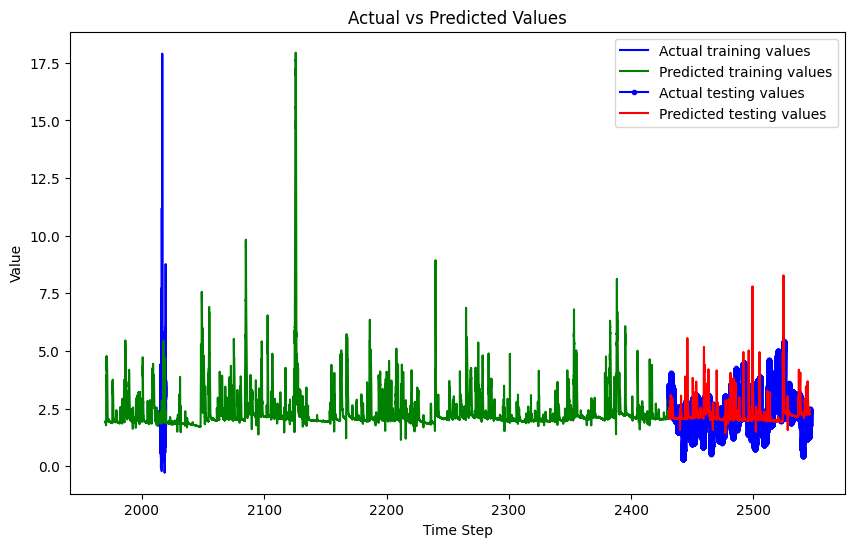

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(target_train_conv, 'blue', label='Actual training values')
plt.plot(train_predictions_conv, 'green', label='Predicted training values')

plt.plot(range(len(target_train_conv), len(target_train_conv) + len(target_test_conv)), target_test_conv, 'blue', marker='.', label='Actual testing values')
plt.plot(range(len(target_train_conv), len(target_train_conv) + len(target_test_conv)), test_predictions_conv, 'red', label='Predicted testing values')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()

**LSTM**

In [ ]:
# Reshape the data for ConvLSTM
features_lstm = np.reshape(features, (features.shape[0], 1, features.shape[1]))


# Split the data sequentially
train_size = int(len(features_lstm) * 0.8)
features_train_lstm, features_test_lstm = features_lstm[:train_size], features_lstm[train_size:]
target_train_lstm, target_test_lstm = target[:train_size], target[train_size:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(features_train.shape[1], features_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(features_train, target_train, epochs=50, verbose=0)


In [ ]:
# Use the trained model to make predictions
train_predictions_lstm = model.predict(features_train_lstm)
test_predictions_lstm = model.predict(features_test_lstm)

1316/1316 [==============================] - 3s 2ms/step


In [ ]:
train_predictions_lstm

array([[1.9396589],
       [1.9348426],
       [1.9396157],
       ...,
       [2.0945807],
       [2.0971448],
       [2.0971448]], dtype=float32)

In [ ]:
target_train_lstm

Date/Time
2015-01-01 00:00:00-06:00    1.70
2015-01-01 00:15:00-06:00    1.71
2015-01-01 00:30:00-06:00    1.72
2015-01-01 00:45:00-06:00    1.72
2015-01-01 01:00:00-06:00    1.72
                             ... 
2019-10-20 13:00:00-06:00    3.40
2019-10-20 13:15:00-06:00    3.40
2019-10-20 13:30:00-06:00    3.41
2019-10-20 13:45:00-06:00    3.43
2019-10-20 14:00:00-06:00    3.43
Name: gage_height_ft_sensor_07380120, Length: 168344, dtype: float64

In [ ]:
test_predictions_lstm

array([[2.0997095],
       [2.0971065],
       [2.094544 ],
       ...,
       [2.5024662],
       [2.5187032],
       [2.53374  ]], dtype=float32)

In [ ]:
target_test_lstm

Date/Time
2019-10-20 14:15:00-06:00    3.44
2019-10-20 14:30:00-06:00    3.43
2019-10-20 14:45:00-06:00    3.45
2019-10-20 15:00:00-06:00    3.44
2019-10-20 15:15:00-06:00    3.47
                             ... 
2020-12-31 22:45:00-06:00    2.38
2020-12-31 23:00:00-06:00    2.37
2020-12-31 23:15:00-06:00    2.35
2020-12-31 23:30:00-06:00    2.35
2020-12-31 23:45:00-06:00    2.33
Name: gage_height_ft_sensor_07380120, Length: 42087, dtype: float64

In [ ]:


# Calculate the mean squared error of the predictions
train_mse_lstm = mean_squared_error(target_train_lstm, train_predictions_lstm)
test_mse_lstm = mean_squared_error(target_test_lstm, test_predictions_lstm)

print("Train MSE Lstm:", train_mse_lstm)
print("Test MSE Lstm:", test_mse_lstm)

Train MSE Lstm: 0.7092734639871006
Test MSE Lstm: 0.6104951009213032


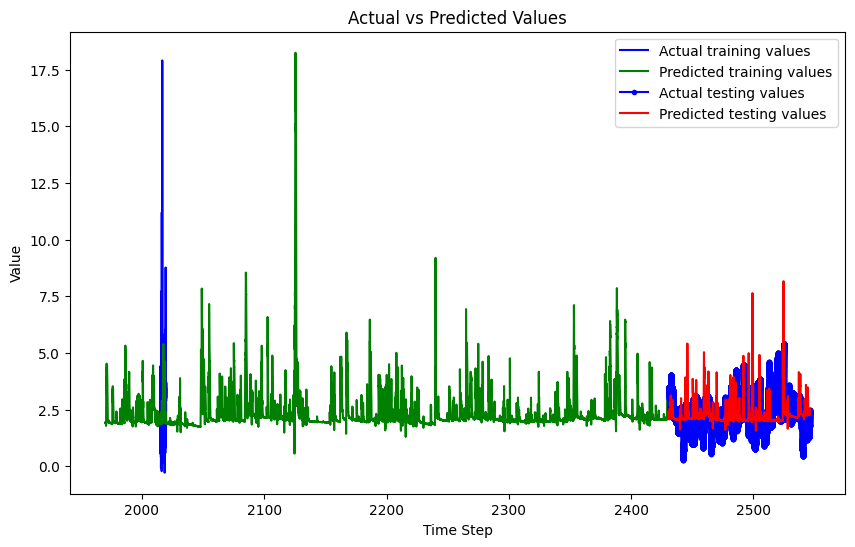

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(target_train_lstm, 'blue', label='Actual training values')
plt.plot(train_predictions_lstm, 'green', label='Predicted training values')

plt.plot(range(len(target_train_lstm), len(target_train_lstm) + len(target_test_lstm)), target_test_lstm, 'blue', marker='.', label='Actual testing values')
plt.plot(range(len(target_train_lstm), len(target_train_lstm) + len(target_test_lstm)), test_predictions_lstm, 'red', label='Predicted testing values')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()

# **GRU MODEL**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(features_train_lstm.shape[1], features_train_lstm.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(features_train_lstm, target_train_lstm, epochs=50, verbose=0)


In [ ]:
train_predictions_GRU = model.predict(features_train_lstm)
test_predictions_GRU = model.predict(features_test_lstm)

1316/1316 [==============================] - 3s 2ms/step


In [ ]:
train_predictions_GRU

array([[1.9544704],
       [1.9496741],
       [1.9544778],
       ...,
       [2.0909772],
       [2.0933454],
       [2.0933454]], dtype=float32)

In [ ]:
test_predictions_GRU

array([[2.0957122],
       [2.0932333],
       [2.0908678],
       ...,
       [2.430118 ],
       [2.4459617],
       [2.4611619]], dtype=float32)

In [ ]:
train_mse_GRU = mean_squared_error(target_train_lstm, train_predictions_GRU)
test_mse_GRU = mean_squared_error(target_test_lstm, test_predictions_GRU)

print("Train MSE GRU:", train_mse_GRU)
print("Test MSE GRU:", test_mse_GRU)

Train MSE GRU: 0.7089473186725042
Test MSE GRU: 0.6396560436792199


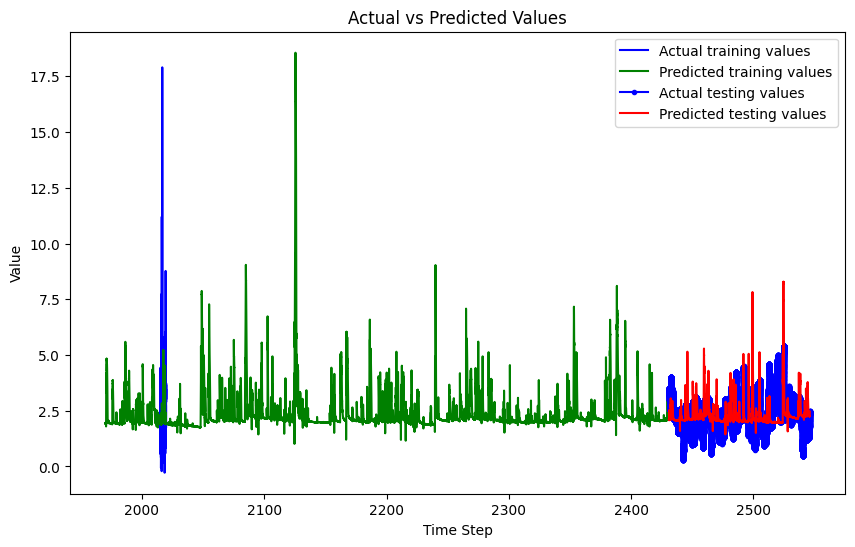

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(target_train_lstm, 'blue', label='Actual training values')
plt.plot(train_predictions_GRU, 'green', label='Predicted training values')

plt.plot(range(len(target_train_lstm), len(target_train_lstm) + len(target_test_lstm)), target_test_lstm, 'blue', marker='.', label='Actual testing values')
plt.plot(range(len(target_train_lstm), len(target_train_lstm) + len(target_test_lstm)), test_predictions_GRU, 'red', label='Predicted testing values')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()

# GNN

In [ ]:
import torch
from torch import nn

# Define model
class GTNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GTNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

# Instantiate the model
model = GTNet(input_dim=features_train.shape[1], hidden_dim=64, output_dim=1, num_layers=2)


In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert data to PyTorch tensors
features_train_tensor = torch.Tensor(features_train.values) # Convert DataFrame to numpy array
target_train_tensor = torch.Tensor(target_train.values)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    output = model(features_train_tensor)
    loss = criterion(output.flatten(), target_train_tensor)

    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


RuntimeError: ignored